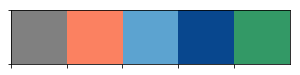

In [1]:
import os
import random
from six.moves import cPickle as pickle
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.patches import Circle
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('text.latex', preamble='\\usepackage{color}')
from PIL import Image
import numpy as np
from scipy.misc import comb
from math import log, exp, sqrt
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
from PIL import Image
import skimage.transform
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

sns.set_context("paper")
# sns.set_context('talk')
import string
import json
import pickle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
%matplotlib inline
blues = sns.color_palette('Blues', 10)
reds = sns.color_palette('Reds')
COLORS = ["#808080", reds[2], blues[5], blues[9], "#339966"]
sns.palplot(sns.color_palette(COLORS))

# from multiprocessing import set_start_method
# try:
#     set_start_method('spawn')
# except RuntimeError:
#     pass

## Config data

In [2]:
# Constants
itow = json.load(open('../data/coco/cocotalk.json', 'r'))['ix_to_word']
WORDS = {int(k): v for k, v in itow.items()}
if 0 not in WORDS:
    WORDS[0] = 'EOS'
MATCH = {v: k for k,v in WORDS.items()}
del itow
FF = pickle.load(open('../data/coco/idf_coco_01.pkl', 'rb'))
F = pickle.load(open('cooc_freq.pkl', 'rb'))[0]
sim_coco = pickle.load(open('../data/Glove/glove_coco_d300_w15_similarities.pkl','rb'))
G2_coco = pickle.load(open('../data/Glove/glove_coco_d300_w15_matrix_tsne2D.pkl', 'rb'))

A = json.load(open('../data/coco/captions_train2014.json', 'r'))['annotations']
caps = {}
for a in A:
    if a['image_id'] in caps:
        caps[a['image_id']].append(a['caption'][:-1].lower().split())
    else:
        caps[a['image_id']] = [a['caption'][:-1].lower().split()]
del A


A = json.load(open('../data/coco/captions_val2014.json', 'r'))['annotations']
caps_val = {}
for a in A:
    if a['image_id'] in caps_val:
        caps_val[a['image_id']].append(a['caption'][:-1].lower().split())
    else:
        caps_val[a['image_id']] = [a['caption'][:-1].lower().split()]
del A

In [3]:
hs = pickle.load(open('../results/fncnn6_reset_topdown_resnet152_msc_track_decode.tr', 'rb'))
ptd_baseline = hs['probas']
decoded_baseline = hs['sampled']
ids  = hs["ids"]
att_baseline = hs["attention"]

hs = pickle.load(open('../results/fncnn6_reset_word_coco_tword009_idf10_a03_topdown_track_decode.tr', 'rb'))
ptd_word = hs['probas']
decoded_word = hs['sampled']
ids  = hs["ids"]
att_word = hs["attention"]

hs = pickle.load(open('../results/fncnn6_reset_combine_importance_qhamming_limited2_tsent03_rcider_tsent05_a04_word_coco_tword009_idf10_a03_topdown_track_decode.tr', 'rb'))
ptd_comb = hs['probas']
decoded_comb = hs['sampled']
att_comb = hs["attention"]

hs = pickle.load(open('../results/fncnn6_reset_importance_qhamming_limited1_tsent017_rcider_tsent05_a04_topdown_track_decode.tr', 'rb'))
ptd_seq = hs['probas']
decoded_seq = hs['sampled']
att_seq = hs["attention"]


In [4]:
cmap = plt.cm.inferno
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)

In [76]:
def plot_pt_decode(pt, sampled, attention, ids, id1=0, id2=0, tag="", shift=0):
    h =  pt[id1][id2]
    indcap = sampled[id1][id2]
    eos = np.where(indcap==MATCH['EOS'])[0]
    if len(eos):
        indcap = indcap[:eos[0]]
    cap = [WORDS[i] for i in indcap]
#     print('caption', cap)
    h = h[:len(indcap), :]
    columns = []
    maxlen = 1
    for e, row in enumerate(h):
        annot = [""] * len(row)
        candidates = []
#         th = np.percentile(row, 99.98)
        th = .8 * np.max(row)
#         highp = np.nonzero(row > th)[0]
        highp = row.argsort()[-4:][::-1]
        highp = [k for k in highp if row[k] > th]
        maxlen = max(maxlen, len(highp))
        found = False
        for k in highp:
            annot[k] = "%.2f" % row[k]
            annot[k] = WORDS[k]
            candidates.append(k)
            if k == indcap[e]:
#                 annot[k] = annot[k]+"*"
                annot[k] = r'\underline{%s}' % annot[k]
                found = True
        if not found:
            print('true token missing!')
            # annot[indcap[e]] = "%.2f*" % row[indcap[e]]
            annot[indcap[e]] = "%s$\star$" % cap[e]
            candidates.append(indcap[e])
        columns.append((candidates, row[candidates], np.array(annot)[candidates]))

    vmin = np.min([np.min(c[1]) for c in columns])
    vmax = np.max([np.max(c[1]) for c in columns])
#     print('min', vmin, 'max', vmax)
    figh = 2 + .6*maxlen
    figw = len(columns) * 1.6 
    gridspec_kw = {"width_ratios": [1] * (len(columns)),
                  "height_ratios": [5, 1.5]}
    heatmapkws = dict(square=False,
                      robust=True,
                      cmap="Blues",
                      linewidths=1.0,
                      vmin=vmin, vmax=vmax,
                      fmt='') 
    cbar_kws=dict(label="$p_\\theta(y_t|h_{t-1})$",
                  format="%.1f",
                  orientation="vertical",
                  )
    annot_kws={'fontsize': 16}
    sns.set()
    sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
    sns.set_context('paper', font_scale=2, rc={"lines.linewidth": 2,
                                                 "lines.markersize": 8})
    im = Image.open(os.path.join("../data/coco/images/", ids[id1][id2]['file_path']))
    idname = ids[id1][id2]['id']
    print('id1:', id1, 'id2:', id2, '>>', idname)
    im = im.resize([224, 224], Image.LANCZOS)
    fig, axes = plt.subplots(2, len(columns), figsize=(figw, figh), gridspec_kw=gridspec_kw)
    for e, (cand, proba, annot) in enumerate(columns):
        yticklabels = [WORDS[k] for k in cand]
        X = proba.T[:, np.newaxis]
        TX = annot.T[:, np.newaxis]
        hm = sns.heatmap(X,
                        ax=axes[1, e],
                        annot=TX, annot_kws=annot_kws,
    #                     cbar= e==len(columns)-1,
                        cbar=False,
                        yticklabels=[],
                        xticklabels=[],  # ['t=1' if not e else e+1],
                        **heatmapkws)
        axes[0, e].imshow(im)
        alp_curr = attention[id1][id2][e].reshape(14, 14)
        alp_im = skimage.transform.pyramid_expand(alp_curr, upscale=16, sigma=20)
        axes[0, e].imshow(alp_im, alpha=.7, cmap=my_cmap)
        axes[0, e].axis('off')
        # axes[e].set_xticks(np.arange(lengths[e])+.5)
        # axes[e].set_yticklabels(yticklabels, rotation='horizontal', fontsize=7)
    # axes[0].annotate('$t$', xy=(0, 0), ha='left', va='top', xycoords='axes fraction', fontsize=20)
#     plt.tight_layout()
    cbaxes = fig.add_axes([.91, 0.15, 0.01, 0.6]) 
    cb = plt.colorbar(axes[1,0].get_children()[0], cax = cbaxes, **cbar_kws)  
    plt.subplots_adjust(hspace=.05, wspace=.01)
    if len(tag):
        cax = fig.add_axes([0.1,0.86,0.6,0.02])
#         1 = 2*shift+len(tag)
        cax.text(x=.05, y=0, s=tag, fontsize=18)
        cax.axis('off')
        plt.savefig('../figures/visatt/%d_%s.png' % (idname, tag), dpi=150,
                   bbox_inches='tight')


id1: 7 id2: 2 >> 336777
id1: 7 id2: 2 >> 336777
id1: 7 id2: 2 >> 336777
id1: 7 id2: 2 >> 336777
id1: 2 id2: 0 >> 192440
id1: 2 id2: 0 >> 192440
id1: 2 id2: 0 >> 192440
id1: 2 id2: 0 >> 192440
id1: 3 id2: 0 >> 184791
id1: 3 id2: 0 >> 184791
id1: 3 id2: 0 >> 184791
id1: 3 id2: 0 >> 184791
id1: 3 id2: 3 >> 348881
id1: 3 id2: 3 >> 348881
id1: 3 id2: 3 >> 348881
id1: 3 id2: 3 >> 348881


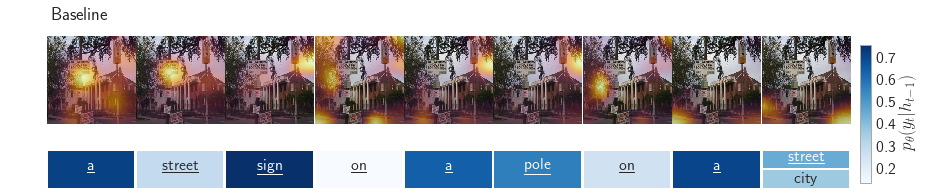

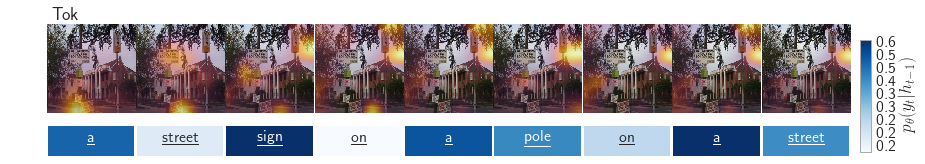

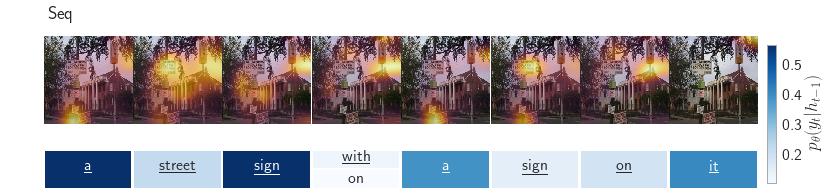

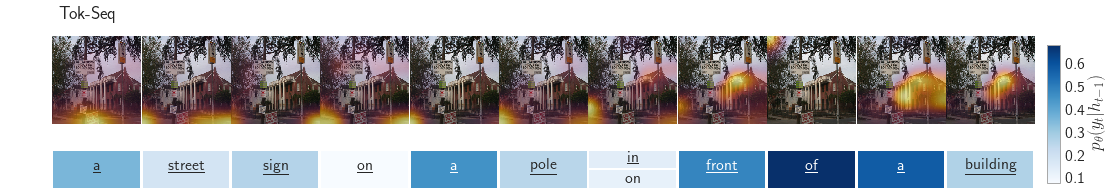

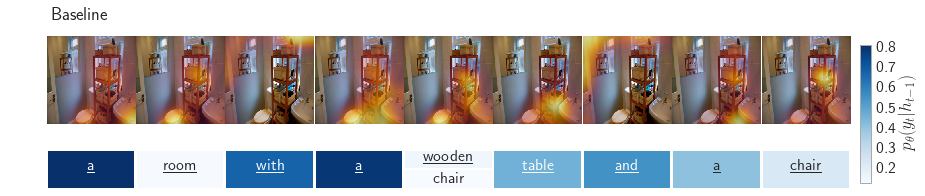

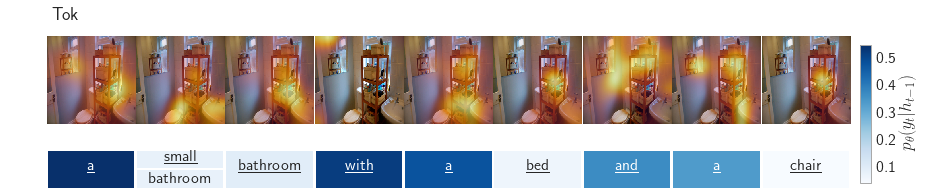

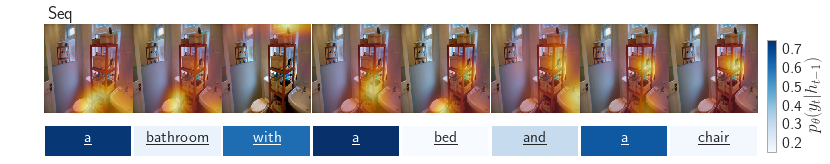

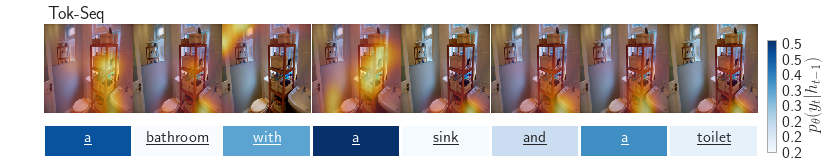

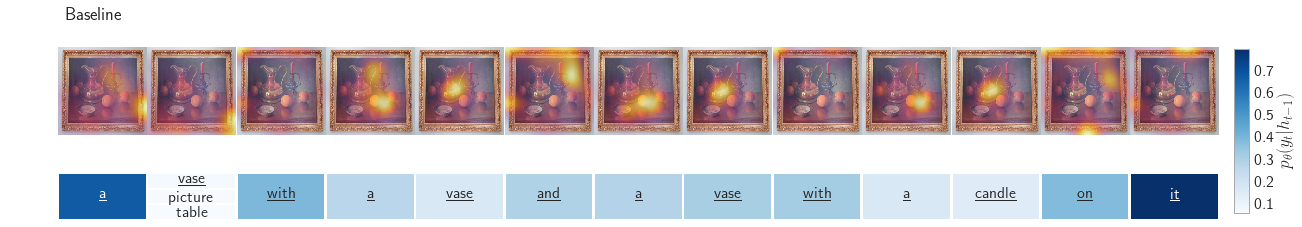

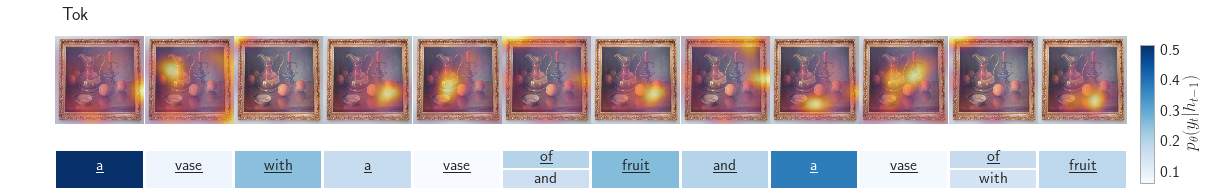

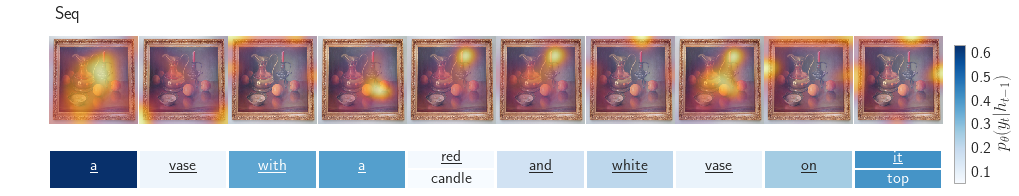

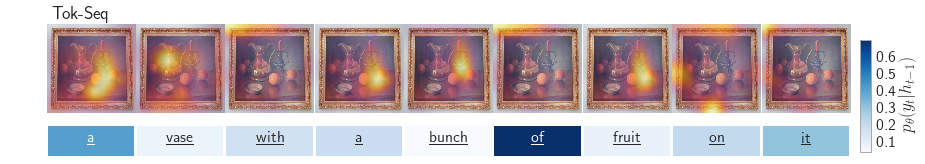

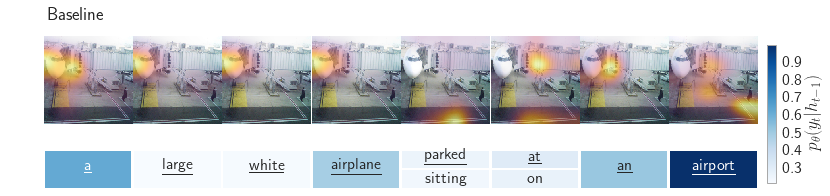

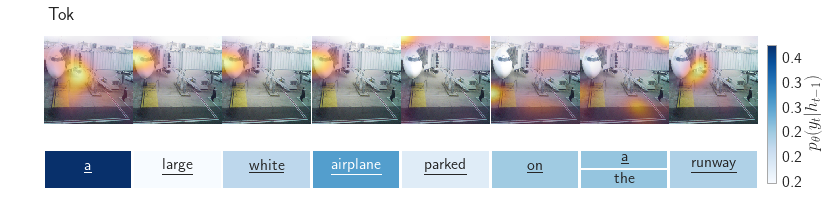

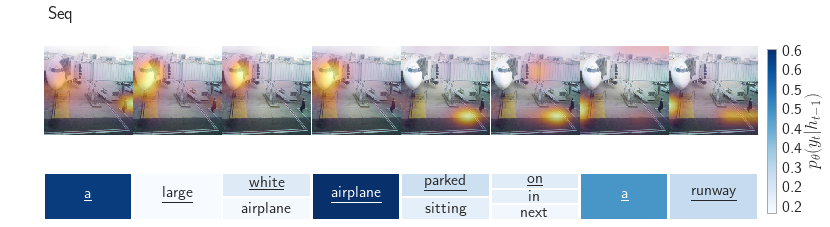

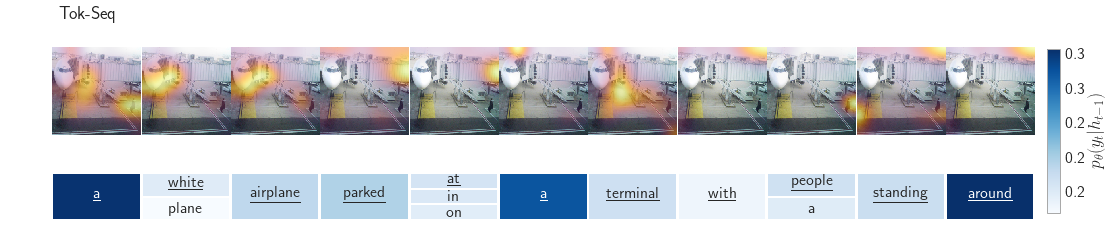

In [77]:
for id1, id2 in zip([7, 2, 3, 3],[2, 0, 0, 3]):
# for id1 , id2 in zip([5],[2]):
        idname = ids[id1][id2]['id']
        plot_pt_decode(ptd_baseline, decoded_baseline, att_baseline, ids, id1=id1, id2=id2, tag="Baseline")
        plot_pt_decode(ptd_word, decoded_word, att_word, ids, id1=id1, id2=id2, tag='Tok')
        plot_pt_decode(ptd_seq, decoded_seq, att_seq, ids,  id1=id1, id2=id2, tag="Seq")
        plot_pt_decode(ptd_comb, decoded_comb, att_comb, ids,  id1=id1, id2=id2, tag="Tok-Seq")

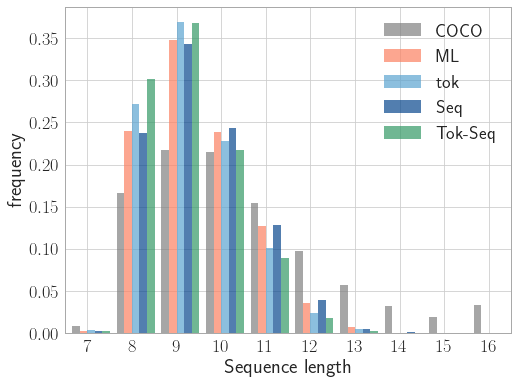

In [97]:
L = pickle.load(open('../results/lengths.p', 'rb'))
train = Counter([min(len(c), 16) for imid in caps for c in caps[imid]])
baseline = Counter(L['save/fncnn6_reset_topdown_resnet152_msc'])
tok = Counter(L['save/fncnn6_reset_word_coco_tword009_idf10_a03_topdown'])
seq =Counter(L['save/fncnn6_reset_importance_qhamming_limited1_tsent017_rcider_tsent05_a04_topdown'])
comb = Counter(L['save/fncnn6_reset_combine_importance_qhamming_limited2_tsent03_rcider_tsent05_a04_word_coco_tword009_idf10_a03_topdown'])

sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
f, ax = plt.subplots(1,1, figsize=(8, 6))
e = 0
w = .17
for lab , cnt in zip(['COCO', 'ML', 'tok', 'Seq', 'Tok-Seq'], [train, baseline, tok, seq, comb]):
    sum_cnt = sum(list(cnt.values()))
    cnt_norm = [c/sum_cnt for c in list(cnt.values())]
    xs = np.array(list(cnt)) + (e-2) * w
    ax.bar(xs, cnt_norm, width=w, align='edge', color=COLORS[e], alpha=.7, label=lab)
    e += 1
plt.legend()
plt.xticks(np.arange(7,17))
plt.xlabel('Sequence length')
plt.ylabel('frequency')
plt.xlim(6.5, 16.5)
plt.savefig("../figures/lengths_topdown.png",dpi=300, bbox_inches='tight') 

In [98]:
train.keys()

dict_keys([8, 10, 15, 12, 11, 9, 13, 16, 14, 7, 6, 5])

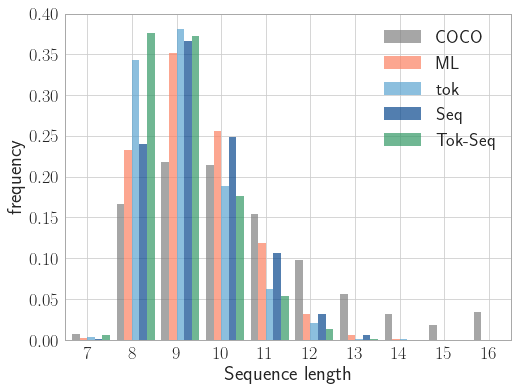

In [101]:
baseline = Counter(L['save/fncnn6_reset_baseline_showtell152'])
tok = Counter(L['save/fncnn6_reset_word_coco_tword009_idf10_a07_showtell152'])
seq =Counter(L['save/fncnn6_reset_importance_qhamming_limited1_tsent017_rcider_tsent05_a04_showtell152'])
comb = Counter(L['save/fncnn6_reset_combine_importance_qhamming_limited2_tsent03_rcider_tsent05_a05_word_coco_tword009_idf10_a07_showtell152'])
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
f, ax = plt.subplots(1,1, figsize=(8, 6))
e = 0
w = .17
for lab , cnt in zip(['COCO', 'ML', 'tok', 'Seq', 'Tok-Seq'], [train, baseline, tok, seq, comb]):
    sum_cnt = sum(list(cnt.values()))
    cnt_norm = [c/sum_cnt for c in list(cnt.values())]
    xs = np.array(list(cnt)) + (e-2) * w
    ax.bar(xs, cnt_norm, width=w, align='edge', color=COLORS[e], alpha=.7, label=lab)
    e += 1
plt.legend()
plt.xticks(np.arange(7,17))
plt.xlim(6.5, 16.5)
plt.xlabel('Sequence length')
plt.ylabel('frequency')
plt.savefig("../figures/lengths_showtell.png",dpi=300, bbox_inches='tight') 

In [151]:
csscores = json.load(open('/home/maha/Downloads/evalimgs.json', 'r'))
cids = [a['CIDEr'] for a in csscores]
bestof = np.array(cids).argsort()[-100:]

In [156]:
for k in bestof:
    if k in caps_val:
        print('in val:', k)
    if k in match_ids:
        print('>>>>>', k)

in val: 15660
in val: 33131
in val: 6688
in val: 20481
in val: 28820
in val: 9548
in val: 25860


In [155]:
match_ids = {}
for i in range(len(ids)):
    for j in range(5):
        idname = ids[i][j]['id']
        match_ids[idname] = [i, j]

In [158]:
cids_eval = [cids[k] for k in match_ids]

IndexError: list index out of range

In [12]:
cids_dict = {}
for e, k in enumerate(caps_val):
    cids_dict[k] = cids[e]

NameError: name 'cids' is not defined

In [162]:
len(cids)

40504

In [105]:
def plot_pt_decode_noatt(pts, sampleds, ids, id1=0, id2=0, tag="", addim=0):
    fig = plt.figure()
    cbar_kws=dict(label="$p_\\theta(y_t|h_{t-1})$",
                  format="%.1f",
                  orientation="vertical"
                  )
    annot_kws={'fontsize': 18}
    sns.set()
    sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
    sns.set_context('paper', font_scale=2, rc={"lines.linewidth": 2,
                                                 "lines.markersize": 8})
    im = Image.open(os.path.join("../data/coco/images/", ids[id1][id2]['file_path']))
    idname = ids[id1][id2]['id']
    print('id1:', id1, 'id2:', id2, '>>', idname)
    im = im.resize([200, 200], Image.LANCZOS)
#     nr = 0
    nr = 1
    for pt, sampled in zip(pts, sampleds):
        h =  pt[id1][id2]
        indcap = sampled[id1][id2]
        eos = np.where(indcap==MATCH['EOS'])[0]
        if len(eos):
            indcap = indcap[:eos[0]]
        cap = [WORDS[i] for i in indcap]
    #     print('caption', cap)
        h = h[:len(indcap), :]
        columns = []
        maxlen = 1
        for e, row in enumerate(h):
            annot = [""] * len(row)
            candidates = []
    #         th = np.percentile(row, 99.98)
            th = .99 * np.max(row)
    #         highp = np.nonzero(row > th)[0]
            highp = row.argsort()[-4:][::-1]
            highp = [k for k in highp if row[k] > th]
            maxlen = max(maxlen, len(highp))
            found = False
            for k in highp:
                annot[k] = "%.2f" % row[k]
                annot[k] = WORDS[k]
                candidates.append(k)
                if k == indcap[e]:
    #                 annot[k] = annot[k]+"*"
                    annot[k] = r'\underline{%s}' % annot[k]
                    found = True
            if not found:
                print('true token missing!')
                # annot[indcap[e]] = "%.2f*" % row[indcap[e]]
                annot[indcap[e]] = "%s$\star$" % cap[e]
                candidates.append(indcap[e])
            columns.append((candidates, row[candidates], np.array(annot)[candidates]))
#         vmin = np.min([np.min(c[1]) for c in columns])
#         vmax = np.max([np.max(c[1]) for c in columns])
        vmin = .2
        vmax = .95
        heatmapkws = dict(square=False,
                          robust=True,
                          cmap="Blues",
                          linewidths=1.0,
                          vmin=vmin, vmax=vmax,
                          fmt='')
        for e, (cand, proba, annot) in enumerate(columns):
            width = .18
            height = .26
            hax = fig.add_axes([width*e, height*nr, width, height-.12])
            if nr == 1:
                keepax = hax
            yticklabels = [WORDS[k] for k in cand]
            X = proba.T[:, np.newaxis]
            TX = annot.T[:, np.newaxis]
            hm = sns.heatmap(X,
                            ax=hax,
                            annot=TX, annot_kws=annot_kws,
                            cbar=False,
                            yticklabels=[],
                            xticklabels=[],  # ['t=1' if not e else e+1],
                            **heatmapkws)
        nr += 1
    imax = fig.add_axes([-.32, 0.05 , .3, .85]) 
    imax.imshow(im)
    imax.axis('off')
#     cbaxes = fig.add_axes([2.22,0.1,0.02,0.5])
    cbaxes = fig.add_axes([2.4,0.19,0.02,0.5])
    cb = plt.colorbar(keepax.get_children()[0], cax = cbaxes, **cbar_kws)  
    tagax = fig.add_axes([0, .0,0.5,.7])
    tagax.text(0.02,.6, "Baseline")
    tagax.text(0.02,.98, "Tok-Seq")
#     tagax.text(0,.56, "Tok")
#     tagax.text(0,.9, "Seq")
#     tagax.text(0,1.215, "Tok-Seq")
    tagax.axis('off')
# #     plt.subplots_adjust(hspace=.05, wspace=.01)
#     if len(tag):
#         cax = fig.add_axes([0.127,0.985,0.6,0.02])
#         cax.text(x=.0, y=0, s=tag, fontsize=18)
#         cax.axis('off')
    plt.savefig('../figures/visatt_wo/%d.png' % (idname), dpi=150,
               bbox_inches='tight')
# # 

id1: 2 id2: 1 >> 1146


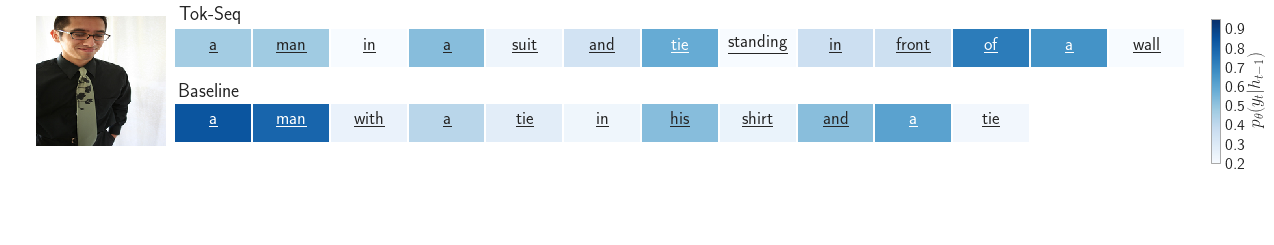

In [106]:
# for id1, id2 in zip([5, 6, 2, 2, 4, 4],[2, 3, 1,4, 2, 3]):
# (4, 2), (2,1)
for id1 , id2 in zip([2],[1]):
    idname = ids[id1][id2]['id']
    plot_pt_decode_noatt([ptd_baseline, ptd_comb],  [decoded_baseline, decoded_comb], ids, id1=id1, id2=id2, tag="Baseline", addim=1)
#     plot_pt_decode_noatt(ptd_word, decoded_word, att_word, ids, id1=id1, id2=id2, tag='Tok')
#     plot_pt_decode_noatt(ptd_seq, decoded_seq, att_seq, ids,  id1=id1, id2=id2, tag="Seq")
#     plot_pt_decode_noatt(ptd_comb, decoded_comb, att_comb, ids,  id1=id1, id2=id2, tag="Tok-Seq")